# Importing ONNX models to Menoh (Haskell binding)

We'll show how you can import ONNX models into [Menoh](https://github.com/pfnet-research/menoh), and use the imported model for inference.

Menoh has language bindings for C, C++, C#, Go, Haskell, Node.js, OCaml, Ruby, and Rust, but here we use Haskell binding for this tutorial.

First let's import some modules and also check the version of Menoh itself and its Haskell binding.

In [1]:
{-# LANGUAGE ScopedTypeVariables #-}
import Control.Applicative
import Control.Monad
import System.FilePath
import Text.Printf
import Menoh

In [2]:
Menoh.version

Version {versionBranch = [1,0,2], versionTags = []}

In [3]:
Menoh.bindingVersion

Version {versionBranch = [0,2,0], versionTags = []}

## Step 1: Prepare ONNX model and sample input image

In this example, we will demonstrate importing a VGG16 model, a model for image classification. The model was converted to ONNX using [onnx-chainer](https://github.com/chainer/onnx-chainer) from [Chainer](https://chainer.org/)'s [VGG16Layers](https://docs.chainer.org/en/stable/reference/generated/chainer.links.VGG16Layers.html).

First we need to download the pre-trained model file and class definition file and sample input image.

In [4]:
dataDir = "data"

In [5]:
import Control.Monad.Trans.Resource
import Data.Conduit.Binary (sinkFile)
import Network.HTTP.Simple
import System.Directory

downloadTo :: String -> FilePath -> IO ()
downloadTo req fname = do
  b <- doesFileExist fname
  unless b $ do
    putStrLn $ req ++ " -> " ++ fname
    request <- parseRequest req
    runResourceT $ httpSink request $ \_ -> sinkFile fname

In [6]:
downloadTo "https://www.dropbox.com/s/bjfn9kehukpbmcm/VGG16.onnx?dl=1" $ dataDir </> "VGG16.onnx"
downloadTo "https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt" $ dataDir </> "synset_words.txt"
downloadTo "https://upload.wikimedia.org/wikipedia/commons/5/54/Light_sussex_hen.jpg" $ dataDir </> "Light_sussex_hen.jpg"

https://www.dropbox.com/s/bjfn9kehukpbmcm/VGG16.onnx?dl=1 -> data/VGG16.onnx

https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt -> data/synset_words.txt

https://upload.wikimedia.org/wikipedia/commons/5/54/Light_sussex_hen.jpg -> data/Light_sussex_hen.jpg

## Step 2: Loading ONNX model

Now that we have downloaded an ONNX model file, let's load the model data into Menoh. The `model_data` contains computation graph structure and weights of layers.

In [7]:
-- Load ONNX model data
model_data <- makeModelDataFromONNX (dataDir </> "VGG16.onnx")

Then we specify its inputs and outputs:

In [8]:
batch_size  = 1
channel_num = 3
height = 224
width  = 224
category_num = 1000

input_dims, output_dims :: Dims
input_dims  = [batch_size, channel_num, height, width]
output_dims = [batch_size, category_num]

-- Aliases to onnx's node input and output tensor name
conv1_1_in_name  = "140326425860192"
fc6_out_name     = "140326200777584"
softmax_out_name = "140326200803680"

In [9]:
-- Specify inputs and outputs
vpt <- makeVariableProfileTable
         [(conv1_1_in_name, DTypeFloat, input_dims)]
         [(fc6_out_name, DTypeFloat), (softmax_out_name, DTypeFloat)]
         model_data
optimizeModelData model_data vpt

Having specified inputs and outputs, we construct an inference engine with MKL-DNN as backend.

In [10]:
-- Construct computation primitive list and memories
model <- makeModel vpt model_data "mkldnn"

##  Step 3: Prepare input for inference

Next, we prepare an input image for inference.

In [11]:
import qualified Codec.Picture as Picture

crop :: Picture.Pixel a => Picture.Image a -> Picture.Image a
crop img = Picture.generateImage (\x y -> Picture.pixelAt img (base_x + x) (base_y + y)) shortEdge shortEdge
  where
    shortEdge = min (Picture.imageWidth img) (Picture.imageHeight img)
    base_x = (Picture.imageWidth  img - shortEdge) `div` 2
    base_y = (Picture.imageHeight img - shortEdge) `div` 2

-- TODO: Should we do some kind of interpolation?
resize :: Picture.Pixel a => (Int,Int) -> Picture.Image a -> Picture.Image a
resize (w,h) img = Picture.generateImage (\x y -> Picture.pixelAt img (x * orig_w `div` w) (y * orig_h `div` h)) w h
  where
    orig_w = Picture.imageWidth  img
    orig_h = Picture.imageHeight img

In [12]:
image <- do
  ret <- Picture.readImage $ dataDir </> "Light_sussex_hen.jpg"
  case ret of
    Left e -> error e
    Right img -> return $ resize (width,height) $ crop $ Picture.convertRGB8 img

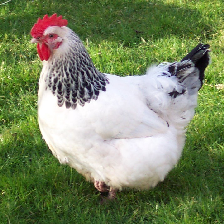

In [13]:
image

## Step 3: Run inference

Now that we have prepared a Menoh inference engine and input image. It's time to run an inference.

In [14]:
import qualified Data.Vector as V
import qualified Data.Vector.Generic as VG
import qualified Data.Vector.Storable as VS

-- VGG16.onnx assumes BGR channel ordering and floating point pixel value
convert :: Picture.Image Picture.PixelRGB8 -> VS.Vector Float
convert img = VS.generate (3 * Picture.imageHeight img * Picture.imageWidth img) f
  where
    f i =
      case Picture.pixelAt img x y of
        Picture.PixelRGB8 r g b ->
          case ch of
            0 -> fromIntegral b
            1 -> fromIntegral g
            2 -> fromIntegral r
            _ -> undefined
      where
        (ch,m) = i `divMod` (Picture.imageWidth img * Picture.imageHeight img)
        (y,x) = m `divMod` Picture.imageWidth img

In [15]:
-- Copy input image data to model's input array
writeBuffer model conv1_1_in_name [convert image]

-- Run inference
run model

-- Get output
([fc6_out] :: [VS.Vector Float]) <- readBuffer model fc6_out_name
([softmax_out] :: [VS.Vector Float]) <- readBuffer model softmax_out_name

## Step 4: Examine the results

Finally, let's examine the results.

In [16]:
import Data.List
import Data.Ord

categories <- fmap lines $ readFile $ dataDir </> "synset_words.txt"
let k = 5
scores <- forM [0 .. VG.length softmax_out - 1] $ \i ->
  return (i, softmax_out VG.! i)
printf "top %d categories are:\n" k
forM_ (take k $ sortBy (flip (comparing snd)) scores) $ \(i,p) ->
  printf "%0.1f%%: %s\n" (p * 100) (categories !! i)

top 5 categories are:

95.8%: n01514859 hen
4.0%: n01514668 cock
0.2%: n01807496 partridge
0.0%: n01797886 ruffed grouse, partridge, Bonasa umbellus
0.0%: n01847000 drake

The top-ranked class is "hen" and the the second is "cock". The result looks reasonable for the image.